In [1]:
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import schema

In [2]:
signal_params = [
    {
        'freq_hz': 1,
        'ampl': 1.0,
        'phase_rad': 0.0
    }
]

sampling_freq_hz: float = 10
sampling_duration_s = 50

In [3]:
delay_injection = 10
delay_amplitude = 0.1

sampling_int = 1.0 / sampling_freq_hz

proper_sampling = np.arange(0, sampling_duration_s + sampling_int, sampling_int, dtype=np.float64)

interval_priority_sampling = proper_sampling + np.heaviside(np.arange(-1 * delay_injection, sampling_duration_s - delay_injection + sampling_int, sampling_int), 1) * delay_amplitude

increment_priority_sampling = proper_sampling.copy()
increment_priority_sampling[delay_injection] += delay_amplitude

n_samples = len(proper_sampling)

sampling_behaviors = {
    'Original': proper_sampling,
    'Interval': interval_priority_sampling,
    'Increment': increment_priority_sampling
}

In [4]:
class SigGen:
    def __init__(self, params: List[Dict[str, float]]):
        signal_params_schema = schema.Schema(
            [
                {
                    'freq_hz': schema.Or(int, float),
                    'ampl': schema.Or(int, float),
                    'phase_rad': schema.Or(int, float)
                }
            ]
        )
        signal_params_schema.validate(params)
        self._params = params
    
    def add_signal(self, freq_hz: float, ampl: float, phase_rad: float):
        self._params.append({
            'freq_hz': freq_hz,
            'ampl': ampl,
            'phase_rad': phase_rad
        })
    
    def generate(self, t: np.ndarray) -> np.ndarray:
        output = np.zeros(t.shape, t.dtype)
        for component in signal_params:
            output += component['ampl'] * np.sin(t * 2 * np.pi * component['freq_hz'] + component['phase_rad'])
        return output
    
    def __call__(self, t: np.ndarray) -> np.ndarray:
        return self.generate(t)

sig_gen = SigGen(signal_params)

In [6]:
reference_signal = sig_gen(proper_sampling)
reference_spectrum = np.fft.rfft(reference_signal)

signals = {label:sig_gen(sampling_sequence)
           for label, sampling_sequence in sampling_behaviors.items()}
spectra = {label:np.fft.rfft(signal) for label, signal in signals.items()}
fft_freq = {label:np.fft.rfftfreq(len(timing), sampling_int)
            for label, timing in sampling_behaviors.items()}

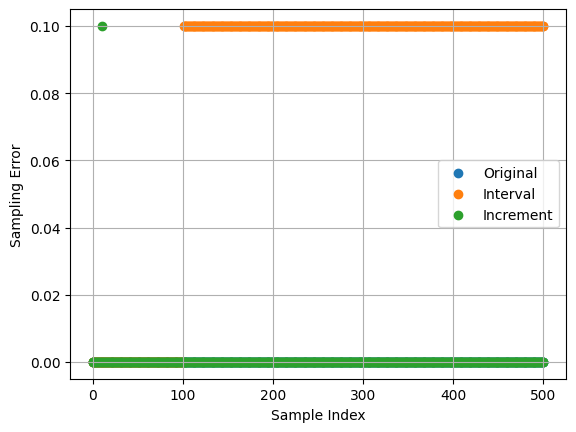

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

for label, sequence in sampling_behaviors.items():
    ax.scatter(np.arange(len(sequence)), sequence - proper_sampling, label=label)
ax.legend()
ax.set_ylabel('Sampling Error')
ax.set_xlabel('Sample Index')
ax.grid()

Text(0.5, 0, 'Time (s)')

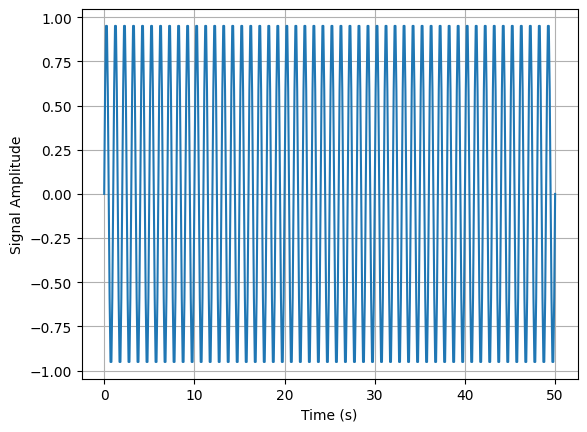

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(proper_sampling, reference_signal)
ax.grid()

ax.set_ylabel('Signal Amplitude')
ax.set_xlabel('Time (s)')

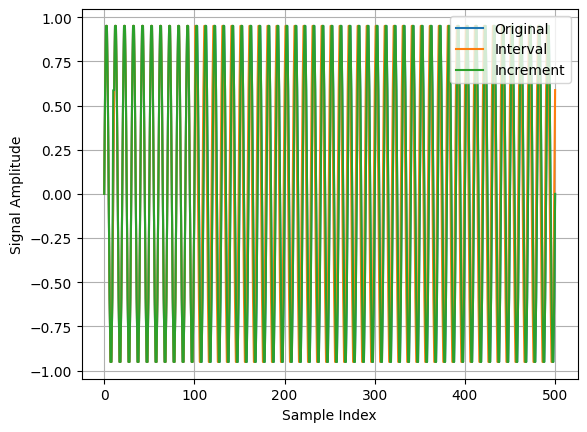

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)

for label, signal in signals.items():
    ax.plot(np.arange(len(signal)), signal, label=label)

ax.grid()
ax.set_ylabel('Signal Amplitude')
ax.set_xlabel('Sample Index')
ax.legend()

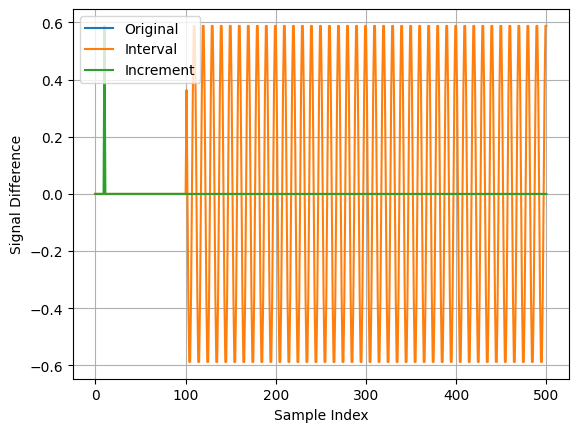

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

for label, signal in signals.items():
    ax.plot(np.arange(len(signal)), signal - reference_signal, label=label)

ax.grid()
ax.set_ylabel('Signal Difference')
ax.set_xlabel('Sample Index')
ax.legend()

(1e-06, 6.05910211371837)

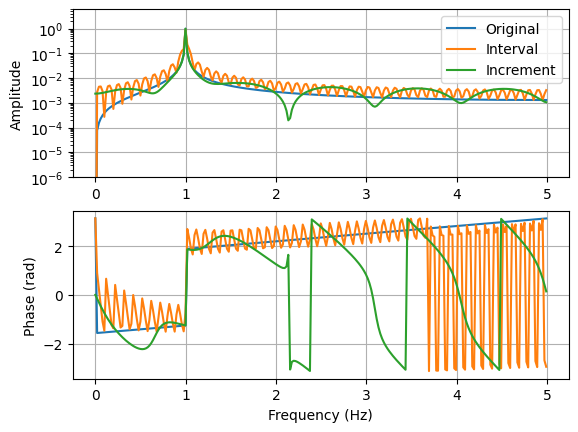

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

for label in spectra:
    ax1.plot(fft_freq[label], 2 / n_samples * np.abs(spectra[label]), label=label)
    ax2.plot(fft_freq[label], np.angle(spectra[label]))

ax1.grid()
ax2.grid()
ax1.set_ylabel('Amplitude')
ax2.set_ylabel('Phase (rad)')
ax2.set_xlabel('Frequency (Hz)')
ax1.legend()
ax1.semilogy()
ax1.set_ylim(1e-6)

Text(0.5, 0, 'Frequency (Hz)')

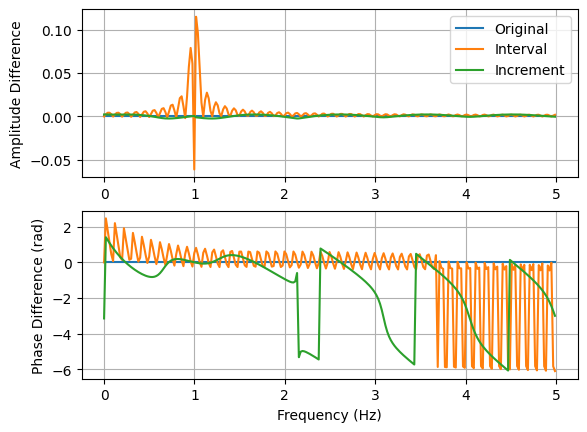

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex=ax1)

for label in spectra:
    ax1.plot(fft_freq[label], 2 / n_samples * (np.abs(spectra[label]) - np.abs(reference_spectrum)), label=label)
    ax2.plot(fft_freq[label], np.angle(spectra[label]) - np.angle(reference_spectrum))

ax1.grid()
ax2.grid()
ax1.legend()
ax1.set_ylabel('Amplitude Difference')
ax2.set_ylabel('Phase Difference (rad)')
ax2.set_xlabel('Frequency (Hz)')